# Lesson 7 ニューラルネットでゲームを攻略するAIをつくろう

## 目次

- Section 1 解説
    - 1.1 強化学習とは
    - 1.2 強化学習の定式化
    - 1.3 Temporal Difference (TD) 学習
    - 1.4 Q学習
    - 1.5 Deep Q学習
    - 1.6 Checkクイズ
- Section 2 実装①
    - 2.1 OpenAI Gymについて
    - 2.2 Coalb上でのレンダリングについて
    - 2.3 DQNでCartPole
- Section 3 テクニック・発展的内容
    - 3.1 Prioritized Experience Replay
    - 3.2 Double DQN
    - 3.3 Dueling Network
    - 3.4 Checkクイズ
- Section 4 実装②
    - 4.1 DQN + テクニックでBreakout
- Section 5 ケーススタディ

### Checkクイズの解答
問1: ③, 問2: ①

## Section 4 実装②

このSectionでは、Section3で紹介したテクニック

- Prioritized Experience Replay
- Double Deep Q-Network
- Dueiling Network

を使ってAtariのゲームの一つであるBreakout (ブロック崩し) をプレイ・攻略してみます。

In [1]:
import os
import math

import gym
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten, Lambda, Add
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from skimage.color import rgb2gray
from skimage.transform import resize

### 4.1. DQN + テクニックでBreakout (ブロック崩し)

Breakout
- state: サイズ`(210, 160, 3)`の`np.ndarary`
- action
    - 0: 動かない
    - 1: 新しい玉を発射
    - 2: 右に移動
    - 3: 左に移動
- reward
    - 0.0: ブロックを崩さなかった
    - 1.0: ブロックを崩した
- terminal
    - False: エピソード継続
    - True: エピソード終了（5機失うと終わり）

#### 4.1.1 各構成要素の実装

そのままの画像ではサイズが大きすぎるので、画像を縮小した上でグレースケール化します。

In [2]:
def preprocess(obs, last_obs):
    processed_obs = np.maximum(obs, last_obs)
    processed_obs = rgb2gray(processed_obs)*255# rgb to gray
    processed_obs = resize(processed_obs, (84,84), mode='reflect').astype(np.uint8) # 84x84
    return processed_obs

マルコフ性を満たすために、連続する4つのフレームをstackしてネットワークに入力します。
したがって、入力次元は84x84x4となります。

In [3]:
def get_initial_state(next_obs, obs):
    processed_obs = preprocess(next_obs, obs)
    state = np.stack([processed_obs for _ in range(4)], axis=2)
    return state

In [4]:
def get_state(state, next_obs):
    state = np.concatenate([state[:, :, 1:], next_obs[:, :, None]], axis=2)
    return state

ネットワークにはCNNを用います。

In [5]:
# 損失関数
def huber_loss(y_true, y_pred):
    error = K.abs(y_pred - y_true)
    quadratic_part = K.clip(error, 0.0, 1.0)
    linear_part = error - quadratic_part
    loss = K.sum(0.5*K.square(quadratic_part) + linear_part)
    return loss

In [6]:
def build_cnn():
    inputs = Input(shape=(84, 84, 4))

    # 84x84x4 -> 20x20x32
    z = Conv2D(32, kernel_size=(8, 8), strides=(4, 4), activation='relu')(inputs)
    # 20x20x32 -> 9x9x64
    z = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), activation='relu')(z)
    # 9x9x64 ->  7x7x64
    z = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(z)
    #  7x7x64 -> 3136
    z = Flatten()(z)
    
    # Dueling Architecture --------
    # State value
    z_s = Dense(512, activation='relu')(z)
    z_s = Dense(1)(z_s)
    # Advantage value
    z_a = Dense(512, activation='relu')(z)
    z_a = Dense(4)(z_a)
    z_a = Lambda(lambda x: x - K.stop_gradient(K.mean(x, axis=1, keepdims=True)))(z_a)
    
    y = Add()([z_s, z_a])

    model = Model(inputs, y)

    model.compile(RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), huber_loss)

    return model

Prioritized Experience Replayを実現するために、 各履歴におけるTD誤差をもとにサンプリングを行うクラスを実装します。

In [7]:
class PrioritizedReplayMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = []
    
    def __len__(self):
        return len(self.memory)
    
    def append(self, transition):
        self.memory.append(transition)
        self.memory = self.memory[-self.memory_size:]
        
    def make_prob(self, td_errors, alpha=0.5, eps=np.float32(0.001)):
        abs_td_errors = np.power(np.abs(td_errors) + eps, alpha)
        return abs_td_errors / np.sum(abs_td_errors)
    
    def td_error_update(self, batch_indexes):
        for i in batch_indexes:
            q = model.predict(self.memory[i]['state'][None] / 255.).flatten()
            new_q = model_target.predict(self.memory[i]['next_state'][None] / 255.).flatten()
            self.memory[i]['td_error'] = self.memory[i]['reward'] + (1-self.memory[i]['terminal']) * gamma * np.max(new_q) - q[self.memory[i]['action']]
    
    def sample(self, batch_size):
        td_errors = [self.memory[index]['td_error'] for index in range(len(self.memory))]
        #抽出確率の計算
        p = self.make_prob(td_errors)
        #抽出確率を元にサンプリングする経験を決定
        batch_indexes = np.random.choice(len(self.memory), size=batch_size, p=p).tolist()
        #TD誤差の更新
        self.td_error_update(batch_indexes)
        #経験のサンプリング
        state      = np.array([self.memory[index]['state'] for index in batch_indexes])
        next_state = np.array([self.memory[index]['next_state'] for index in batch_indexes])
        reward     = np.array([self.memory[index]['reward'] for index in batch_indexes])
        action     = np.array([self.memory[index]['action'] for index in batch_indexes])
        terminal   = np.array([self.memory[index]['terminal'] for index in batch_indexes])
        
        return {'state': state, 'next_state': next_state, 'reward': reward, 'action': action, 'terminal': terminal}

In [8]:
def copy_weights(model_original, model_target):
    for i, layer in enumerate(model_original.layers):
        model_target.layers[i].set_weights(layer.get_weights())
    return model_target

#### 4.1.2 Replay Memoryへの経験の貯蓄

Cartpoleと同様、 あらかじめMemoryに経験をためておきます。

In [9]:
memory_size = 200000
initial_memory_size = 20000
n_actions = 4

In [10]:
env = gym.make('BreakoutDeterministic-v4')

replay_memory = PrioritizedReplayMemory(memory_size)

step = 0

while True:
    obs = env.reset()
    next_obs, _, _, _ = env.step(0)
    
    next_state = get_initial_state(next_obs, obs)
    terminal = False
    
    while not terminal:
        obs = next_obs
        state = next_state
        
        action = np.random.randint(0, n_actions)
        
        next_obs, reward, terminal, _ = env.step(action)
        reward = np.sign(reward)
        
        processed_obs = preprocess(next_obs, obs)
        
        next_state = get_state(state, processed_obs)
        
        transition = {
            'td_error': reward,
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'terminal': int(terminal)
        }
        replay_memory.append(transition)
        
        step += 1
        
        if (step + 1) % 1000 == 0:
            print('Number of frames:', step + 1)
    
    if step >= initial_memory_size:
        break

Number of frames: 1000
Number of frames: 2000
Number of frames: 3000
Number of frames: 4000
Number of frames: 5000
Number of frames: 6000
Number of frames: 7000
Number of frames: 8000
Number of frames: 9000
Number of frames: 10000
Number of frames: 11000
Number of frames: 12000
Number of frames: 13000
Number of frames: 14000
Number of frames: 15000
Number of frames: 16000
Number of frames: 17000
Number of frames: 18000
Number of frames: 19000
Number of frames: 20000


#### 4.1.3 学習

DQNの学習には非常に時間がかかるので注意してください。(数十時間~数日)

ネットワークの構築

In [11]:
model = build_cnn()
model_target = build_cnn()

eps_start = 1.0
eps_end = 0.1
n_steps = 500

gamma = 0.99
target_update_interval = 10**4
n_noop_steps = 30
train_interval = 4

batch_size = 32

def get_eps(step):
    return max(0.1, (eps_end - eps_start)/n_steps * step + eps_start)

n_episodes = 3000 # 学習を行うエピソード数

def create_target(y, _t, action, n_actions):
    one_hot = to_categorical(action, n_actions)
    t = (1 - one_hot) * y + one_hot * _t[:, None]
    
    return t

step = 0

In [12]:
def train(batch_size):
    batch = replay_memory.sample(batch_size)
    
    q = model.predict(batch['state'] / 255.)
    q_next = model.predict(batch['next_state'] / 255.) 
    q_target_next = model_target.predict(batch['next_state'] / 255.)
    
    a_next = q_next.argmax(1) # (batch_size,)
    a_next_onehot = to_categorical(a_next, n_actions) # (batch_size, n_actions)
    
    _t = batch['reward'] + (1 - batch['terminal']) * gamma * (q_target_next * a_next_onehot).sum(1)
    t = create_target(q, _t, batch['action'], n_actions)
    
    return model.fit(batch['state'] / 255., t, epochs=1, verbose=0)

n_episodesの数だけ学習を行います。（学習済みの重みを試す場合は飛ばしてください。）

In [13]:
for episode in range(n_episodes):
    obs = env.reset()
    next_obs, _, terminal, _ = env.step(0)
    for _ in range(np.random.randint(n_noop_steps)):
        obs = next_obs
        next_obs, _, _, _ = env.step(0)
    next_state = get_initial_state(next_obs, obs)
    
    total_reward = 0
    total_q_max = []
    while not terminal:
        obs = next_obs
        state = next_state
        
        q = model.predict(state[None] / 255.).flatten()
        total_q_max.append(np.max(q))
        
        eps = get_eps(step)
        if np.random.random() < eps:
            action = np.random.randint(0, n_actions)
        else:
            action = np.argmax(q)
        next_obs, reward, terminal, _ = env.step(action)
        processed_obs = preprocess(next_obs, obs)
        reward = np.sign(reward)
        total_reward += reward
        next_state = get_state(state, processed_obs)
        
        #TD誤差の計算
        new_q = model_target.predict(next_state[None] / 255.).flatten()
        td_error = reward + (1-terminal) * gamma * np.max(new_q) - q[action]
        
        transition = {
            'td_error': td_error,
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'terminal': int(terminal)
        }
        replay_memory.append(transition)
        
        #env.render()
        
        if (step + 1) % train_interval == 0:
            train(batch_size)

        if (step + 1) % target_update_interval == 0:
            model_target = copy_weights(model, model_target)
        
        step += 1
    
    if (episode + 1) % 10 == 0:
        print('Episode: {}, Reward: {}, Q_max: {:.4f}, eps: {:.4f}'.format(episode + 1, total_reward, np.mean(total_q_max), eps))

KeyboardInterrupt: ignored

#### 4.1.3 テスト

学習させたモデルをテストしてみます。（40時間ほど学習させた重みを利用する場合はLOAD_WEIGHTSをTrueに変更してください.）

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
#学習済みの重みを利用するかどうか
LOAD_WEIGHTS = True
if LOAD_WEIGHTS:
    model.load_weights('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson7/data/param.hdf5')

In [15]:
######Colab上で画面を出力するには以下を実行してください
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display

!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(400, 300))
pydisplay.start()
######

def test(max_steps=5000):
    obs = env.reset()
    next_obs, _, terminal, _ = env.step(0)
    next_state = get_initial_state(next_obs, obs)
    
    total_reward = 0
    step = 0
    while not terminal:
        obs = next_obs
        state = next_state
        
        q = model.predict(state[None]/255.).flatten()
        action = np.argmax(q)
        
        next_obs, reward, terminal, _ = env.step(action)
        processed_obs = preprocess(next_obs, obs)
        total_reward += reward
        next_state = get_state(state, processed_obs)
        ######Colab上で画面を出力するには以下をコメントアウトしてください
        env.render()
        ######
        step += 1
        
        ######Colab上で画面を出力するには以下を実行してください
        screen = env.render(mode='rgb_array')

        plt.imshow(screen)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        ######
        
        if step > max_steps:
            break
    return total_reward

KeyboardInterrupt: ignored

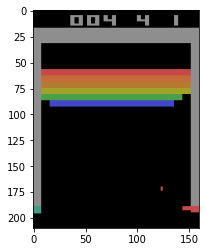

In [16]:
test()